In [1]:
#Vasil Stamenkoski
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import random
import tensorflow as tf
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
df = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=['Date'], index_col=0).sort_index()
df['Close'] = df['Close'].str.replace(',', '')
df['Close'] = df['Close'].astype(float)
df.drop(columns=['Volume'], inplace=True)
for idx in df.index:
    if df.loc[idx, 'Close'] > df.loc[idx, 'High']:
        df.loc[idx, 'Close'] = df.loc[idx, 'Close']/2

In [3]:
df.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409,533.712258
std,151.904442,153.008811,150.552807,151.618792
min,279.120000,281.210000,277.220000,278.760000
25%,404.115000,406.765000,401.765000,404.527500
50%,537.470000,540.750000,532.990000,537.532500
75%,654.922500,662.587500,644.800000,652.172500
max,816.680000,816.680000,805.140000,813.110000


In [4]:
px.line(df)

## 1. MANY TO ONE UNIVARIATE - CLOSE

In [5]:
def create_sequences(data, look_back=1): # many to one UNIVARIATE:
    dataX, dataY = [], []
    for i in range(len(data) - look_back-1):
        dataX.append(data[i:(i+look_back), :])
        dataY.append(data[i+look_back, :])
    return np.array(dataX), np.array(dataY)

In [6]:
close_data = df[['Close']].values
idx = int(0.8*close_data.shape[0])
close_train = close_data[:idx]
close_test = close_data[idx:]
print(close_train.shape)
print(close_test.shape)

(1006, 1)
(252, 1)


In [7]:
LOOKBACK = 30
close_trainX, close_trainY = create_sequences(close_train, look_back=LOOKBACK)
close_testX, close_testY = create_sequences(close_test, look_back=LOOKBACK)

In [8]:
print(close_trainX.shape)
print(close_trainY.shape)
print(close_testX.shape)
print(close_testY.shape)

(975, 30, 1)
(975, 1)
(221, 30, 1)
(221, 1)


### HOMEWORK 1:
TRY DIFFERENT ARCHITECTURES
DROPOUT, BATCHNORM, STACK or remove LSTMs...
LOOKBACK PERIOD 

In [9]:
# HOMEWORK 1:
# TRY DIFFERENT ARCHITECTURES
# DROPOUT, BATCHNORM, STACK or remove LSTMs...
# LOOKBACK PERIOD 
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(LOOKBACK, 1),return_sequences=True))
model.add(LSTM(60, activation='relu', input_shape=(LOOKBACK, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 60)                38640     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 79501 (310.55 KB)
Trainable params: 79501 (310.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
es_cbk = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [11]:
model_history = model.fit(
    close_trainX,
    close_trainY,
    epochs=10,
    batch_size=1,
    validation_data = (close_testX, close_testY),
    callbacks = [es_cbk]
)

Epoch 1/10
975/975 [==============================] - 10s 9ms/step - loss: 250.6670 - val_loss: 25.4352
Epoch 2/10
975/975 [==============================] - 7s 8ms/step - loss: 28.1569 - val_loss: 29.8731
Epoch 3/10
975/975 [==============================] - 7s 8ms/step - loss: 29.1059 - val_loss: 24.5058
Epoch 4/10
975/975 [==============================] - 8s 8ms/step - loss: 31.3586 - val_loss: 28.5074
Epoch 5/10
975/975 [==============================] - 8s 8ms/step - loss: 32.2987 - val_loss: 30.5221
Epoch 6/10
975/975 [==============================] - 8s 8ms/step - loss: 31.6393 - val_loss: 42.7923
Epoch 7/10
975/975 [==============================] - 8s 8ms/step - loss: 32.1732 - val_loss: 26.3173
Epoch 8/10
975/975 [==============================] - 8s 8ms/step - loss: 32.0714 - val_loss: 26.6517
Epoch 9/10
975/975 [==============================] - 8s 8ms/step - loss: 32.6302 - val_loss: 59.9399
Epoch 10/10
975/975 [==============================] - 8s 8ms/step - loss: 32.08

In [12]:
close_train_pred = model.predict(close_trainX)
close_test_pred = model.predict(close_testX)

7/7 [==============================] - 0s 7ms/step


In [13]:
print(close_test_pred.shape)
print(close_testY.shape)

(221, 1)
(221, 1)


In [14]:
print(mean_absolute_error(close_testY[:, 0], close_test_pred[:, 0]))
print(r2_score(close_testY[:, 0], close_test_pred[:,0]))

28.013255664946264
-0.08264573478809245


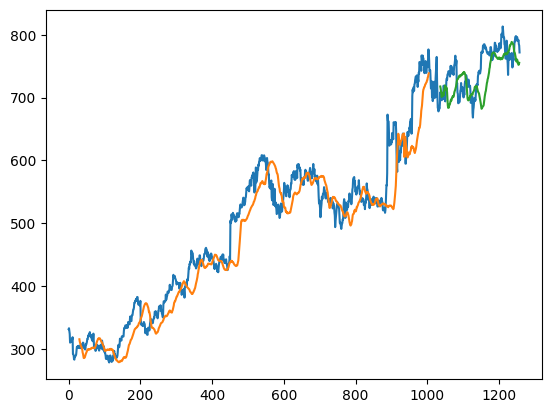

In [15]:
plt.plot(close_data)
train_plot = np.empty_like(close_data)
train_plot[:] = np.nan
train_plot[LOOKBACK:LOOKBACK+len(close_train_pred), :] = close_train_pred

test_plot = np.empty_like(close_data)
test_plot[:] = np.nan
test_plot[len(close_train_pred) + (2*LOOKBACK+1):len(close_data)-1, :] = close_test_pred
plt.plot(train_plot)
plt.plot(test_plot)


## 2. MANY TO ONE MULTIVARIATE

In [16]:
def create_sequences_multi(data, look_back, feat_idxs, target_idx): # many to one MULTIVARIATE
    dataX, dataY = [], []
    for i in range(len(data) - look_back-1):
        dataX.append(data[i:(i+look_back), feat_idxs])
        dataY.append(data[i+look_back, target_idx])
    return np.array(dataX), np.array(dataY)


In [17]:
t_data = df.values.reshape(*df.shape,1)

In [18]:
split_idx = int(0.8*t_data.shape[0])
t_data_train = t_data[:split_idx]
t_data_test = t_data[split_idx:]
print(t_data_train.shape)
print(t_data_test.shape)

(1006, 4, 1)
(252, 4, 1)


In [19]:
LOOKBACK = 30
FEAT_IDXS = (0,1,2)
TARGET_IDX = 3
N_FEATS = len(FEAT_IDXS)
t_data_trainX, t_data_trainY = create_sequences_multi(
                                    t_data_train,
                                    look_back=LOOKBACK,
                                    feat_idxs = FEAT_IDXS,
                                    target_idx=TARGET_IDX
                                    )
t_data_testX, t_data_testY = create_sequences_multi(
                                    t_data_test,
                                    look_back=LOOKBACK,
                                    feat_idxs = FEAT_IDXS,
                                    target_idx=TARGET_IDX
                                    )

In [20]:
print(t_data_trainX.shape, t_data_trainY.shape)
print(t_data_testX.shape, t_data_testY.shape)

(975, 30, 3, 1) (975, 1)
(221, 30, 3, 1) (221, 1)


In [21]:
t_data_trainX = t_data_trainX.squeeze()
t_data_testX = t_data_testX.squeeze()

In [22]:
print(t_data_trainX.shape, t_data_trainY.shape)
print(t_data_testX.shape, t_data_testY.shape)

(975, 30, 3) (975, 1)
(221, 30, 3) (221, 1)


In [23]:
print(df.head(5))

              Open    High     Low    Close
Date                                       
2012-01-03  325.25  332.83  324.97  331.795
2012-01-04  331.27  333.87  329.08  333.225
2012-01-05  329.83  330.75  326.89  328.605
2012-01-06  328.34  328.77  323.68  324.120
2012-01-09  322.04  322.29  309.46  310.380


### HOMEWORK 2:
MAKE MANY TO ONE MULTIVARIATE MODEL,
TRY SOME ARCHITECTURES,
TRY WITH DIFFERENT FEATURES

In [24]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']].values)

In [25]:
seq_length = 60
train_size = int(len(scaled_df) * 0.8)
x_train = []
y_train = []
for i in range(seq_length, train_size):
    x_train.append(scaled_df[i-seq_length:i])
    y_train.append(scaled_df[i])
x_train, y_train = np.array(x_train), np.array(y_train)

x_test = []
y_test = []
for i in range(train_size + seq_length, len(scaled_df)):
    x_test.append(scaled_df[i-seq_length:i])
    y_test.append(scaled_df[i])
x_test, y_test = np.array(x_test), np.array(y_test)

In [26]:
# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 4), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
30/30 [==============================] - 6s 46ms/step - loss: 0.0270
Epoch 2/10
30/30 [==============================] - 1s 48ms/step - loss: 0.0025
Epoch 3/10
30/30 [==============================] - 1s 45ms/step - loss: 0.0018
Epoch 4/10
30/30 [==============================] - 1s 45ms/step - loss: 0.0015
Epoch 5/10
30/30 [==============================] - 1s 45ms/step - loss: 0.0017
Epoch 6/10
30/30 [==============================] - 1s 45ms/step - loss: 0.0013
Epoch 7/10
30/30 [==============================] - 1s 46ms/step - loss: 0.0013
Epoch 8/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0017
Epoch 9/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0014
Epoch 10/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0013


In [28]:
test_loss = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)

6/6 [==============================] - 1s 18ms/step - loss: 0.0012
Test loss: 0.0012376973172649741


In [29]:
# Make predictions
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

6/6 [==============================] - 1s 19ms/step


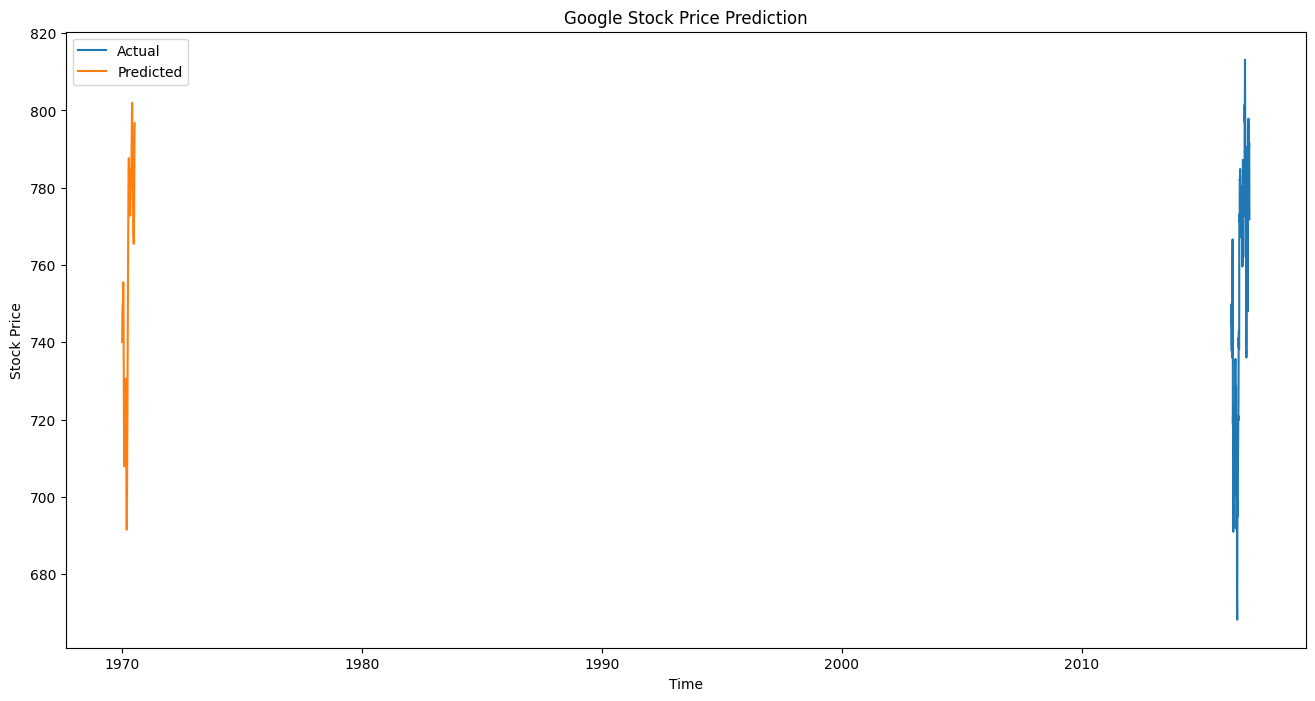

In [30]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'][train_size+seq_length:], label='Actual')
plt.plot(y_pred[:, 3], label='Predicted')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### HOMEWORK 3: MANY TO MANY UNIVARIATE

In [79]:
# Split the dataset into training and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [80]:
# Scale the dataset using a MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df)
test_data = scaler.transform(test_df)


In [81]:
# Function to create input-output pairs for the model
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:i+seq_length+1])
    return np.array(X), np.array(y)

seq_length = 10

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [82]:
# Convert the data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [83]:
# Reshape the data to match the input shape of the model
X_train = X_train.numpy().reshape((X_train.shape[0], X_train.shape[1], 4))
y_train = y_train.numpy().reshape((y_train.shape[0], y_train.shape[1], 4))
X_test = X_test.numpy().reshape((X_test.shape[0], X_test.shape[1], 4))
y_test = y_test.numpy().reshape((y_test.shape[0], y_test.shape[1], 4))

In [74]:
# # Reshape the data to match the input shape of the model
# X_train = tf.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
# y_train = tf.reshape(y_train, (y_train.shape[0], y_train.shape[1], 4))
# X_test = tf.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
# y_test = tf.reshape(y_test, (y_test.shape[0], y_test.shape[1], 4))

In [84]:
# Define and train the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(seq_length, 4), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4))
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.0986 - val_loss: 0.2233
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0422 - val_loss: 0.1163
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0675
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0171 - val_loss: 0.0386
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0236
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.0126
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 10/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 11/50
32/32 

In [85]:
# Get the model's predictions on the test data
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 3ms/step


In [86]:
# Inverse transform the scaled data to get actual stock prices
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 4))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 4))

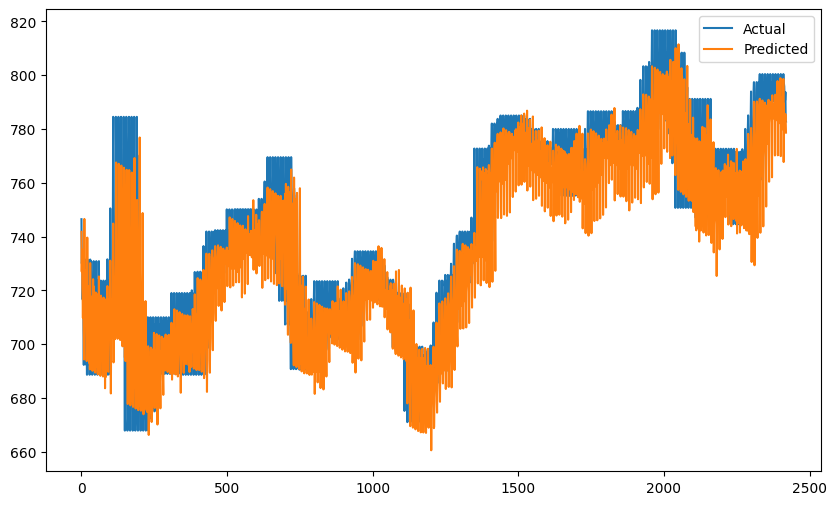

In [87]:
# Plot the actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:, 0], label='Actual')
plt.plot(y_pred_inv[:, 0], label='Predicted')
plt.legend()
plt.show()

In [ ]:
#Vasil Stamenkoski